# PeakVI: Analyzing scATACseq data

PeakVI is used for analyzing scATACseq data. This tutorial walks through how to read, set-up and train the model, accessing and visualizing the latent space, and differential accessibility. We use the 5kPBMC sample dataset from 10X but these steps can be easily adjusted for other datasets.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import scanpy as sc
import scvi
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

## Download and preprocess data

First we need to download the sample data - we will use the `pooch` package to do this.

In [5]:
def download_data(save_path: str, fname: str = "atac_pbmc_5k") -> str:
    """Download the data files."""
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz",
        known_hash="78e536a1508108fa5bd3b411a7484809c011f3403800369b20db05bdbfeb2284",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    return str(Path(data_paths[0]).parent)

In [6]:
data_path = download_data(save_dir.name)

  0%|                                               | 0.00/114M [00:00<?, ?B/s]

  2%|▋                                     | 2.21M/114M [00:00<00:05, 22.0MB/s]

  7%|██▌                                   | 7.76M/114M [00:00<00:02, 41.7MB/s]

 10%|███▉                                  | 11.9M/114M [00:00<00:05, 17.6MB/s]

 13%|████▉                                 | 14.7M/114M [00:00<00:06, 16.2MB/s]

 19%|███████▏                              | 21.5M/114M [00:01<00:04, 18.9MB/s]

 21%|███████▉                              | 23.7M/114M [00:01<00:05, 15.8MB/s]

 24%|█████████▏                            | 27.7M/114M [00:01<00:04, 18.0MB/s]

 26%|█████████▉                            | 29.8M/114M [00:01<00:05, 16.3MB/s]

 28%|██████████▊                           | 32.3M/114M [00:01<00:04, 17.5MB/s]

 31%|███████████▋                          | 35.1M/114M [00:02<00:04, 16.0MB/s]

 37%|██████████████                        | 42.1M/114M [00:02<00:04, 16.8MB/s]

 42%|████████████████                      | 48.1M/114M [00:02<00:02, 22.9MB/s]

 46%|█████████████████▍                    | 52.4M/114M [00:02<00:02, 23.6MB/s]

 52%|███████████████████▊                  | 59.3M/114M [00:02<00:01, 28.9MB/s]

 55%|████████████████████▊                 | 62.6M/114M [00:03<00:02, 24.9MB/s]

 59%|██████████████████████▎               | 67.1M/114M [00:03<00:01, 28.7MB/s]

 62%|███████████████████████▍              | 70.4M/114M [00:03<00:02, 18.5MB/s]

 64%|████████████████████████▍             | 73.3M/114M [00:03<00:02, 20.0MB/s]

 67%|█████████████████████████▌            | 76.8M/114M [00:03<00:02, 17.2MB/s]

 71%|███████████████████████████           | 81.3M/114M [00:04<00:01, 21.5MB/s]

 74%|████████████████████████████          | 84.1M/114M [00:04<00:02, 14.8MB/s]

 77%|█████████████████████████████▎        | 87.9M/114M [00:04<00:01, 15.4MB/s]

 79%|██████████████████████████████▏       | 90.5M/114M [00:04<00:01, 14.3MB/s]

 83%|███████████████████████████████▋      | 94.9M/114M [00:04<00:01, 19.0MB/s]

 86%|████████████████████████████████▍     | 97.5M/114M [00:05<00:00, 17.7MB/s]

 88%|██████████████████████████████████▍    | 101M/114M [00:05<00:00, 14.1MB/s]

 96%|█████████████████████████████████████▌ | 110M/114M [00:05<00:00, 25.8MB/s]

  0%|                                               | 0.00/114M [00:00<?, ?B/s]

100%|████████████████████████████████████████| 114M/114M [00:00<00:00, 251GB/s]

Untarring contents of '/tmp/tmpgce9lagt/atac_pbmc_5k' to '/tmp/tmpgce9lagt/atac_pbmc_5k.untar'


PeakVI expects as input an AnnData object with a cell-by-region matrix. There are various pipelines that handle preprocessing of scATACseq to obtain this matrix from the sequencing data. If the data was generated by 10X genomics, this matrix is among the standard outputs of CellRanger. Other pipelines, like [SnapATAC](https://github.com/r3fang/SnapATAC/) and [ArchR](https://www.archrproject.com/bookdown/add-peak-matrix.html), also generate similar matrices.

In the case of 10X data, PeakVI has a special reader function `scvi.data.read_10x_atac` that reads the files and creates an AnnData object, demonstrated below. For conveniece, we also demonstrate how to initialize an AnnData object from scratch.

Throughout this tutorial, we use [sample scATACseq data from 10X of 5K PBMCs](https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_5k_nextgem).

In [7]:
adata = scvi.data.read_10x_atac(data_path)
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'

We can use Scanpy to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [8]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 115554


# regions after filtering: 33142


## Set up, train, save, and load the model

We can now set up the AnnData object with PeakVI, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [9]:
scvi.model.PEAKVI.setup_anndata(adata)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



We can now create a PeakVI model object and train it!

```{important}
The default `max_epochs` is set to `500`, but in practice PeakVI stops early once the model converges (we quantify convergence with the model's validation reconstruction loss). This is especially the case for larger datasets, which require fewer training epochs to converge since each epoch lets the model view more data. 

This means that the estimated training runtime is usually an overestimate of the actual runtime. For the data used in this tutorial, it typically converges with around half of `max_epochs`!
```

In [10]:
model = scvi.model.PEAKVI(adata)
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 1/500 [00:00<08:05,  1.03it/s]

Epoch 1/500:   0%|          | 1/500 [00:00<08:05,  1.03it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=2.74e+8]

Epoch 2/500:   0%|          | 1/500 [00:00<08:05,  1.03it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=2.74e+8]

Epoch 2/500:   0%|          | 2/500 [00:01<05:25,  1.53it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=2.74e+8]

Epoch 2/500:   0%|          | 2/500 [00:01<05:25,  1.53it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=2.6e+8] 

Epoch 3/500:   0%|          | 2/500 [00:01<05:25,  1.53it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=2.6e+8]

Epoch 3/500:   1%|          | 3/500 [00:01<04:33,  1.82it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=2.6e+8]

Epoch 3/500:   1%|          | 3/500 [00:01<04:33,  1.82it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=2.49e+8]

Epoch 4/500:   1%|          | 3/500 [00:01<04:33,  1.82it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=2.49e+8]

Epoch 4/500:   1%|          | 4/500 [00:02<04:08,  1.99it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=2.49e+8]

Epoch 4/500:   1%|          | 4/500 [00:02<04:08,  1.99it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.41e+8]

Epoch 5/500:   1%|          | 4/500 [00:02<04:08,  1.99it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.41e+8]

Epoch 5/500:   1%|          | 5/500 [00:02<03:54,  2.11it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.41e+8]

Epoch 5/500:   1%|          | 5/500 [00:02<03:54,  2.11it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.36e+8]

Epoch 6/500:   1%|          | 5/500 [00:02<03:54,  2.11it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.36e+8]

Epoch 6/500:   1%|          | 6/500 [00:03<03:46,  2.18it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.36e+8]

Epoch 6/500:   1%|          | 6/500 [00:03<03:46,  2.18it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.33e+8]

Epoch 7/500:   1%|          | 6/500 [00:03<03:46,  2.18it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.33e+8]

Epoch 7/500:   1%|▏         | 7/500 [00:03<03:40,  2.23it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.33e+8]

Epoch 7/500:   1%|▏         | 7/500 [00:03<03:40,  2.23it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=2.3e+8]  

Epoch 8/500:   1%|▏         | 7/500 [00:03<03:40,  2.23it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=2.3e+8]

Epoch 8/500:   2%|▏         | 8/500 [00:03<03:37,  2.27it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=2.3e+8]

Epoch 8/500:   2%|▏         | 8/500 [00:03<03:37,  2.27it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.29e+8]

Epoch 9/500:   2%|▏         | 8/500 [00:03<03:37,  2.27it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.29e+8]

Epoch 9/500:   2%|▏         | 9/500 [00:04<03:34,  2.29it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.29e+8]

Epoch 9/500:   2%|▏         | 9/500 [00:04<03:34,  2.29it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=2.28e+8]

Epoch 10/500:   2%|▏         | 9/500 [00:04<03:34,  2.29it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=2.28e+8]

Epoch 10/500:   2%|▏         | 10/500 [00:04<03:32,  2.30it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=2.28e+8]

Epoch 10/500:   2%|▏         | 10/500 [00:04<03:32,  2.30it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=2.27e+8]

Epoch 11/500:   2%|▏         | 10/500 [00:04<03:32,  2.30it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=2.27e+8]

Epoch 11/500:   2%|▏         | 11/500 [00:05<03:31,  2.31it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=2.27e+8]

Epoch 11/500:   2%|▏         | 11/500 [00:05<03:31,  2.31it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=2.25e+8]

Epoch 12/500:   2%|▏         | 11/500 [00:05<03:31,  2.31it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=2.25e+8]

Epoch 12/500:   2%|▏         | 12/500 [00:05<03:30,  2.32it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=2.25e+8]

Epoch 12/500:   2%|▏         | 12/500 [00:05<03:30,  2.32it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.23e+8]

Epoch 13/500:   2%|▏         | 12/500 [00:05<03:30,  2.32it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.23e+8]

Epoch 13/500:   3%|▎         | 13/500 [00:06<03:29,  2.33it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.23e+8]

Epoch 13/500:   3%|▎         | 13/500 [00:06<03:29,  2.33it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=2.21e+8]

Epoch 14/500:   3%|▎         | 13/500 [00:06<03:29,  2.33it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=2.21e+8]

Epoch 14/500:   3%|▎         | 14/500 [00:06<03:28,  2.33it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=2.21e+8]

Epoch 14/500:   3%|▎         | 14/500 [00:06<03:28,  2.33it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.19e+8]

Epoch 15/500:   3%|▎         | 14/500 [00:06<03:28,  2.33it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.19e+8]

Epoch 15/500:   3%|▎         | 15/500 [00:06<03:27,  2.33it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.19e+8]

Epoch 15/500:   3%|▎         | 15/500 [00:06<03:27,  2.33it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.18e+8] 

Epoch 16/500:   3%|▎         | 15/500 [00:06<03:27,  2.33it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.18e+8]

Epoch 16/500:   3%|▎         | 16/500 [00:07<03:27,  2.33it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.18e+8]

Epoch 16/500:   3%|▎         | 16/500 [00:07<03:27,  2.33it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.17e+8]

Epoch 17/500:   3%|▎         | 16/500 [00:07<03:27,  2.33it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.17e+8]

Epoch 17/500:   3%|▎         | 17/500 [00:07<03:27,  2.33it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.17e+8]

Epoch 17/500:   3%|▎         | 17/500 [00:07<03:27,  2.33it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.17e+8]

Epoch 18/500:   3%|▎         | 17/500 [00:07<03:27,  2.33it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.17e+8]

Epoch 18/500:   4%|▎         | 18/500 [00:08<03:26,  2.33it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.17e+8]

Epoch 18/500:   4%|▎         | 18/500 [00:08<03:26,  2.33it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.16e+8] 

Epoch 19/500:   4%|▎         | 18/500 [00:08<03:26,  2.33it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.16e+8]

Epoch 19/500:   4%|▍         | 19/500 [00:08<03:25,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.16e+8]

Epoch 19/500:   4%|▍         | 19/500 [00:08<03:25,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.16e+8]

Epoch 20/500:   4%|▍         | 19/500 [00:08<03:25,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.16e+8]

Epoch 20/500:   4%|▍         | 20/500 [00:09<03:25,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.16e+8]

Epoch 20/500:   4%|▍         | 20/500 [00:09<03:25,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.16e+8]

Epoch 21/500:   4%|▍         | 20/500 [00:09<03:25,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.16e+8]

Epoch 21/500:   4%|▍         | 21/500 [00:09<03:24,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.16e+8]

Epoch 21/500:   4%|▍         | 21/500 [00:09<03:24,  2.34it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.15e+8]

Epoch 22/500:   4%|▍         | 21/500 [00:09<03:24,  2.34it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.15e+8]

Epoch 22/500:   4%|▍         | 22/500 [00:09<03:24,  2.34it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.15e+8]

Epoch 22/500:   4%|▍         | 22/500 [00:09<03:24,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.15e+8]

Epoch 23/500:   4%|▍         | 22/500 [00:09<03:24,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.15e+8]

Epoch 23/500:   5%|▍         | 23/500 [00:10<03:23,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.15e+8]

Epoch 23/500:   5%|▍         | 23/500 [00:10<03:23,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.15e+8]

Epoch 24/500:   5%|▍         | 23/500 [00:10<03:23,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.15e+8]

Epoch 24/500:   5%|▍         | 24/500 [00:10<03:23,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.15e+8]

Epoch 24/500:   5%|▍         | 24/500 [00:10<03:23,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.14e+8]

Epoch 25/500:   5%|▍         | 24/500 [00:10<03:23,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.14e+8]

Epoch 25/500:   5%|▌         | 25/500 [00:11<03:23,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.14e+8]

Epoch 25/500:   5%|▌         | 25/500 [00:11<03:23,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.14e+8]

Epoch 26/500:   5%|▌         | 25/500 [00:11<03:23,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.14e+8]

Epoch 26/500:   5%|▌         | 26/500 [00:11<03:22,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.14e+8]

Epoch 26/500:   5%|▌         | 26/500 [00:11<03:22,  2.34it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.14e+8]

Epoch 27/500:   5%|▌         | 26/500 [00:11<03:22,  2.34it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.14e+8]

Epoch 27/500:   5%|▌         | 27/500 [00:12<03:22,  2.34it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.14e+8]

Epoch 27/500:   5%|▌         | 27/500 [00:12<03:22,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.13e+8]

Epoch 28/500:   5%|▌         | 27/500 [00:12<03:22,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.13e+8]

Epoch 28/500:   6%|▌         | 28/500 [00:12<03:21,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.13e+8]

Epoch 28/500:   6%|▌         | 28/500 [00:12<03:21,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.13e+8]

Epoch 29/500:   6%|▌         | 28/500 [00:12<03:21,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.13e+8]

Epoch 29/500:   6%|▌         | 29/500 [00:12<03:21,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.13e+8]

Epoch 29/500:   6%|▌         | 29/500 [00:12<03:21,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.13e+8]

Epoch 30/500:   6%|▌         | 29/500 [00:12<03:21,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.13e+8]

Epoch 30/500:   6%|▌         | 30/500 [00:13<03:20,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.13e+8]

Epoch 30/500:   6%|▌         | 30/500 [00:13<03:20,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.12e+8]

Epoch 31/500:   6%|▌         | 30/500 [00:13<03:20,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.12e+8]

Epoch 31/500:   6%|▌         | 31/500 [00:13<03:20,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.12e+8]

Epoch 31/500:   6%|▌         | 31/500 [00:13<03:20,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.12e+8]

Epoch 32/500:   6%|▌         | 31/500 [00:13<03:20,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.12e+8]

Epoch 32/500:   6%|▋         | 32/500 [00:14<03:20,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.12e+8]

Epoch 32/500:   6%|▋         | 32/500 [00:14<03:20,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.12e+8]

Epoch 33/500:   6%|▋         | 32/500 [00:14<03:20,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.12e+8]

Epoch 33/500:   7%|▋         | 33/500 [00:14<03:19,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.12e+8]

Epoch 33/500:   7%|▋         | 33/500 [00:14<03:19,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.12e+8]

Epoch 34/500:   7%|▋         | 33/500 [00:14<03:19,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.12e+8]

Epoch 34/500:   7%|▋         | 34/500 [00:15<03:19,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.12e+8]

Epoch 34/500:   7%|▋         | 34/500 [00:15<03:19,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.11e+8]

Epoch 35/500:   7%|▋         | 34/500 [00:15<03:19,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.11e+8]

Epoch 35/500:   7%|▋         | 35/500 [00:15<03:18,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.11e+8]

Epoch 35/500:   7%|▋         | 35/500 [00:15<03:18,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.11e+8]

Epoch 36/500:   7%|▋         | 35/500 [00:15<03:18,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.11e+8]

Epoch 36/500:   7%|▋         | 36/500 [00:15<03:18,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.11e+8]

Epoch 36/500:   7%|▋         | 36/500 [00:15<03:18,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.11e+8]

Epoch 37/500:   7%|▋         | 36/500 [00:15<03:18,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.11e+8]

Epoch 37/500:   7%|▋         | 37/500 [00:16<03:17,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.11e+8]

Epoch 37/500:   7%|▋         | 37/500 [00:16<03:17,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.11e+8]

Epoch 38/500:   7%|▋         | 37/500 [00:16<03:17,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.11e+8]

Epoch 38/500:   8%|▊         | 38/500 [00:16<03:17,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.11e+8]

Epoch 38/500:   8%|▊         | 38/500 [00:16<03:17,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.11e+8]

Epoch 39/500:   8%|▊         | 38/500 [00:16<03:17,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.11e+8]

Epoch 39/500:   8%|▊         | 39/500 [00:17<03:17,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.11e+8]

Epoch 39/500:   8%|▊         | 39/500 [00:17<03:17,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.11e+8]

Epoch 40/500:   8%|▊         | 39/500 [00:17<03:17,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.11e+8]

Epoch 40/500:   8%|▊         | 40/500 [00:17<03:16,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.11e+8]

Epoch 40/500:   8%|▊         | 40/500 [00:17<03:16,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.1e+8] 

Epoch 41/500:   8%|▊         | 40/500 [00:17<03:16,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.1e+8]

Epoch 41/500:   8%|▊         | 41/500 [00:18<03:16,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.1e+8]

Epoch 41/500:   8%|▊         | 41/500 [00:18<03:16,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.1e+8]

Epoch 42/500:   8%|▊         | 41/500 [00:18<03:16,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.1e+8]

Epoch 42/500:   8%|▊         | 42/500 [00:18<03:15,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.1e+8]

Epoch 42/500:   8%|▊         | 42/500 [00:18<03:15,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.1e+8]

Epoch 43/500:   8%|▊         | 42/500 [00:18<03:15,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.1e+8]

Epoch 43/500:   9%|▊         | 43/500 [00:18<03:15,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.1e+8]

Epoch 43/500:   9%|▊         | 43/500 [00:18<03:15,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.1e+8]

Epoch 44/500:   9%|▊         | 43/500 [00:18<03:15,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.1e+8]

Epoch 44/500:   9%|▉         | 44/500 [00:19<03:15,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.1e+8]

Epoch 44/500:   9%|▉         | 44/500 [00:19<03:15,  2.34it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=2.1e+8]

Epoch 45/500:   9%|▉         | 44/500 [00:19<03:15,  2.34it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=2.1e+8]

Epoch 45/500:   9%|▉         | 45/500 [00:19<03:14,  2.34it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=2.1e+8]

Epoch 45/500:   9%|▉         | 45/500 [00:19<03:14,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.1e+8]

Epoch 46/500:   9%|▉         | 45/500 [00:19<03:14,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.1e+8]

Epoch 46/500:   9%|▉         | 46/500 [00:20<03:14,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.1e+8]

Epoch 46/500:   9%|▉         | 46/500 [00:20<03:14,  2.34it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.1e+8]

Epoch 47/500:   9%|▉         | 46/500 [00:20<03:14,  2.34it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.1e+8]

Epoch 47/500:   9%|▉         | 47/500 [00:20<03:13,  2.34it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.1e+8]

Epoch 47/500:   9%|▉         | 47/500 [00:20<03:13,  2.34it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.09e+8]

Epoch 48/500:   9%|▉         | 47/500 [00:20<03:13,  2.34it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.09e+8]

Epoch 48/500:  10%|▉         | 48/500 [00:21<03:13,  2.34it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=2.09e+8]

Epoch 48/500:  10%|▉         | 48/500 [00:21<03:13,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.09e+8]

Epoch 49/500:  10%|▉         | 48/500 [00:21<03:13,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.09e+8]

Epoch 49/500:  10%|▉         | 49/500 [00:21<03:12,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.09e+8]

Epoch 49/500:  10%|▉         | 49/500 [00:21<03:12,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.09e+8]

Epoch 50/500:  10%|▉         | 49/500 [00:21<03:12,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.09e+8]

Epoch 50/500:  10%|█         | 50/500 [00:21<03:12,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.09e+8]

Epoch 50/500:  10%|█         | 50/500 [00:21<03:12,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.09e+8]

Epoch 51/500:  10%|█         | 50/500 [00:21<03:12,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.09e+8]

Epoch 51/500:  10%|█         | 51/500 [00:22<03:11,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.09e+8]

Epoch 51/500:  10%|█         | 51/500 [00:22<03:11,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.09e+8]

Epoch 52/500:  10%|█         | 51/500 [00:22<03:11,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.09e+8]

Epoch 52/500:  10%|█         | 52/500 [00:22<03:11,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.09e+8]

Epoch 52/500:  10%|█         | 52/500 [00:22<03:11,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.09e+8] 

Epoch 53/500:  10%|█         | 52/500 [00:22<03:11,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.09e+8]

Epoch 53/500:  11%|█         | 53/500 [00:23<03:11,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.09e+8]

Epoch 53/500:  11%|█         | 53/500 [00:23<03:11,  2.34it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.09e+8]

Epoch 54/500:  11%|█         | 53/500 [00:23<03:11,  2.34it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.09e+8]

Epoch 54/500:  11%|█         | 54/500 [00:23<03:10,  2.34it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.09e+8]

Epoch 54/500:  11%|█         | 54/500 [00:23<03:10,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.09e+8]

Epoch 55/500:  11%|█         | 54/500 [00:23<03:10,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.09e+8]

Epoch 55/500:  11%|█         | 55/500 [00:24<03:10,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.09e+8]

Epoch 55/500:  11%|█         | 55/500 [00:24<03:10,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.09e+8]

Epoch 56/500:  11%|█         | 55/500 [00:24<03:10,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.09e+8]

Epoch 56/500:  11%|█         | 56/500 [00:24<03:09,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.09e+8]

Epoch 56/500:  11%|█         | 56/500 [00:24<03:09,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.09e+8] 

Epoch 57/500:  11%|█         | 56/500 [00:24<03:09,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.09e+8]

Epoch 57/500:  11%|█▏        | 57/500 [00:24<03:09,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.09e+8]

Epoch 57/500:  11%|█▏        | 57/500 [00:24<03:09,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.09e+8]

Epoch 58/500:  11%|█▏        | 57/500 [00:24<03:09,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.09e+8]

Epoch 58/500:  12%|█▏        | 58/500 [00:25<03:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.09e+8]

Epoch 58/500:  12%|█▏        | 58/500 [00:25<03:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.09e+8]

Epoch 59/500:  12%|█▏        | 58/500 [00:25<03:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.09e+8]

Epoch 59/500:  12%|█▏        | 59/500 [00:25<03:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.09e+8]

Epoch 59/500:  12%|█▏        | 59/500 [00:25<03:08,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 60/500:  12%|█▏        | 59/500 [00:25<03:08,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 60/500:  12%|█▏        | 60/500 [00:26<03:08,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 60/500:  12%|█▏        | 60/500 [00:26<03:08,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 61/500:  12%|█▏        | 60/500 [00:26<03:08,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 61/500:  12%|█▏        | 61/500 [00:26<03:07,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 61/500:  12%|█▏        | 61/500 [00:26<03:07,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 62/500:  12%|█▏        | 61/500 [00:26<03:07,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 62/500:  12%|█▏        | 62/500 [00:27<03:07,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 62/500:  12%|█▏        | 62/500 [00:27<03:07,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 63/500:  12%|█▏        | 62/500 [00:27<03:07,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 63/500:  13%|█▎        | 63/500 [00:27<03:06,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 63/500:  13%|█▎        | 63/500 [00:27<03:06,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.08e+8]

Epoch 64/500:  13%|█▎        | 63/500 [00:27<03:06,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.08e+8]

Epoch 64/500:  13%|█▎        | 64/500 [00:27<03:06,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.08e+8]

Epoch 64/500:  13%|█▎        | 64/500 [00:27<03:06,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 65/500:  13%|█▎        | 64/500 [00:27<03:06,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 65/500:  13%|█▎        | 65/500 [00:28<03:05,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 65/500:  13%|█▎        | 65/500 [00:28<03:05,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 66/500:  13%|█▎        | 65/500 [00:28<03:05,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 66/500:  13%|█▎        | 66/500 [00:28<03:05,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 66/500:  13%|█▎        | 66/500 [00:28<03:05,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 67/500:  13%|█▎        | 66/500 [00:28<03:05,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 67/500:  13%|█▎        | 67/500 [00:29<03:05,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 67/500:  13%|█▎        | 67/500 [00:29<03:05,  2.34it/s, v_num=1, train_loss_step=1.06e+7, train_loss_epoch=2.08e+8]

Epoch 68/500:  13%|█▎        | 67/500 [00:29<03:05,  2.34it/s, v_num=1, train_loss_step=1.06e+7, train_loss_epoch=2.08e+8]

Epoch 68/500:  14%|█▎        | 68/500 [00:29<03:04,  2.34it/s, v_num=1, train_loss_step=1.06e+7, train_loss_epoch=2.08e+8]

Epoch 68/500:  14%|█▎        | 68/500 [00:29<03:04,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.08e+8]

Epoch 69/500:  14%|█▎        | 68/500 [00:29<03:04,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.08e+8]

Epoch 69/500:  14%|█▍        | 69/500 [00:30<03:04,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.08e+8]

Epoch 69/500:  14%|█▍        | 69/500 [00:30<03:04,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.08e+8]

Epoch 70/500:  14%|█▍        | 69/500 [00:30<03:04,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.08e+8]

Epoch 70/500:  14%|█▍        | 70/500 [00:30<03:04,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.08e+8]

Epoch 70/500:  14%|█▍        | 70/500 [00:30<03:04,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.08e+8]

Epoch 71/500:  14%|█▍        | 70/500 [00:30<03:04,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.08e+8]

Epoch 71/500:  14%|█▍        | 71/500 [00:30<03:03,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.08e+8]

Epoch 71/500:  14%|█▍        | 71/500 [00:30<03:03,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.08e+8]

Epoch 72/500:  14%|█▍        | 71/500 [00:30<03:03,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.08e+8]

Epoch 72/500:  14%|█▍        | 72/500 [00:31<03:03,  2.34it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.08e+8]

Epoch 72/500:  14%|█▍        | 72/500 [00:31<03:03,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 73/500:  14%|█▍        | 72/500 [00:31<03:03,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 73/500:  15%|█▍        | 73/500 [00:31<03:02,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.08e+8]

Epoch 73/500:  15%|█▍        | 73/500 [00:31<03:02,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.08e+8] 

Epoch 74/500:  15%|█▍        | 73/500 [00:31<03:02,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.08e+8]

Epoch 74/500:  15%|█▍        | 74/500 [00:32<03:02,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.08e+8]

Epoch 74/500:  15%|█▍        | 74/500 [00:32<03:02,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 75/500:  15%|█▍        | 74/500 [00:32<03:02,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 75/500:  15%|█▌        | 75/500 [00:32<03:01,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.08e+8]

Epoch 75/500:  15%|█▌        | 75/500 [00:32<03:01,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.07e+8] 

Epoch 76/500:  15%|█▌        | 75/500 [00:32<03:01,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.07e+8]

Epoch 76/500:  15%|█▌        | 76/500 [00:33<03:01,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.07e+8]

Epoch 76/500:  15%|█▌        | 76/500 [00:33<03:01,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 77/500:  15%|█▌        | 76/500 [00:33<03:01,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 77/500:  15%|█▌        | 77/500 [00:33<03:00,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.08e+8]

Epoch 77/500:  15%|█▌        | 77/500 [00:33<03:00,  2.34it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=2.07e+8]

Epoch 78/500:  15%|█▌        | 77/500 [00:33<03:00,  2.34it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=2.07e+8]

Epoch 78/500:  16%|█▌        | 78/500 [00:33<03:00,  2.34it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=2.07e+8]

Epoch 78/500:  16%|█▌        | 78/500 [00:33<03:00,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.07e+8]

Epoch 79/500:  16%|█▌        | 78/500 [00:33<03:00,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.07e+8]

Epoch 79/500:  16%|█▌        | 79/500 [00:34<02:59,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.07e+8]

Epoch 79/500:  16%|█▌        | 79/500 [00:34<02:59,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.07e+8]

Epoch 80/500:  16%|█▌        | 79/500 [00:34<02:59,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.07e+8]

Epoch 80/500:  16%|█▌        | 80/500 [00:34<02:59,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.07e+8]

Epoch 80/500:  16%|█▌        | 80/500 [00:34<02:59,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.07e+8]

Epoch 81/500:  16%|█▌        | 80/500 [00:34<02:59,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.07e+8]

Epoch 81/500:  16%|█▌        | 81/500 [00:35<02:59,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.07e+8]

Epoch 81/500:  16%|█▌        | 81/500 [00:35<02:59,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.07e+8]

Epoch 82/500:  16%|█▌        | 81/500 [00:35<02:59,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.07e+8]

Epoch 82/500:  16%|█▋        | 82/500 [00:35<02:58,  2.34it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.07e+8]

Epoch 82/500:  16%|█▋        | 82/500 [00:35<02:58,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.07e+8]

Epoch 83/500:  16%|█▋        | 82/500 [00:35<02:58,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.07e+8]

Epoch 83/500:  17%|█▋        | 83/500 [00:36<02:58,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.07e+8]

Epoch 83/500:  17%|█▋        | 83/500 [00:36<02:58,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.07e+8] 

Epoch 84/500:  17%|█▋        | 83/500 [00:36<02:58,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.07e+8]

Epoch 84/500:  17%|█▋        | 84/500 [00:36<02:57,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.07e+8]

Epoch 84/500:  17%|█▋        | 84/500 [00:36<02:57,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 85/500:  17%|█▋        | 84/500 [00:36<02:57,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 85/500:  17%|█▋        | 85/500 [00:36<02:57,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 85/500:  17%|█▋        | 85/500 [00:36<02:57,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.07e+8]

Epoch 86/500:  17%|█▋        | 85/500 [00:36<02:57,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.07e+8]

Epoch 86/500:  17%|█▋        | 86/500 [00:37<02:56,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.07e+8]

Epoch 86/500:  17%|█▋        | 86/500 [00:37<02:56,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.07e+8]

Epoch 87/500:  17%|█▋        | 86/500 [00:37<02:56,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.07e+8]

Epoch 87/500:  17%|█▋        | 87/500 [00:37<02:56,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.07e+8]

Epoch 87/500:  17%|█▋        | 87/500 [00:37<02:56,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.07e+8]

Epoch 88/500:  17%|█▋        | 87/500 [00:37<02:56,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.07e+8]

Epoch 88/500:  18%|█▊        | 88/500 [00:38<02:55,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.07e+8]

Epoch 88/500:  18%|█▊        | 88/500 [00:38<02:55,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 89/500:  18%|█▊        | 88/500 [00:38<02:55,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 89/500:  18%|█▊        | 89/500 [00:38<02:55,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 89/500:  18%|█▊        | 89/500 [00:38<02:55,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 90/500:  18%|█▊        | 89/500 [00:38<02:55,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 90/500:  18%|█▊        | 90/500 [00:39<02:55,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 90/500:  18%|█▊        | 90/500 [00:39<02:55,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.07e+8]

Epoch 91/500:  18%|█▊        | 90/500 [00:39<02:55,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.07e+8]

Epoch 91/500:  18%|█▊        | 91/500 [00:39<02:54,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.07e+8]

Epoch 91/500:  18%|█▊        | 91/500 [00:39<02:54,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 92/500:  18%|█▊        | 91/500 [00:39<02:54,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 92/500:  18%|█▊        | 92/500 [00:39<02:54,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 92/500:  18%|█▊        | 92/500 [00:39<02:54,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.07e+8]

Epoch 93/500:  18%|█▊        | 92/500 [00:39<02:54,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.07e+8]

Epoch 93/500:  19%|█▊        | 93/500 [00:40<02:53,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.07e+8]

Epoch 93/500:  19%|█▊        | 93/500 [00:40<02:53,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.07e+8]

Epoch 94/500:  19%|█▊        | 93/500 [00:40<02:53,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.07e+8]

Epoch 94/500:  19%|█▉        | 94/500 [00:40<02:53,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.07e+8]

Epoch 94/500:  19%|█▉        | 94/500 [00:40<02:53,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.07e+8]

Epoch 95/500:  19%|█▉        | 94/500 [00:40<02:53,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.07e+8]

Epoch 95/500:  19%|█▉        | 95/500 [00:41<02:52,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.07e+8]

Epoch 95/500:  19%|█▉        | 95/500 [00:41<02:52,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 96/500:  19%|█▉        | 95/500 [00:41<02:52,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 96/500:  19%|█▉        | 96/500 [00:41<02:52,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.07e+8]

Epoch 96/500:  19%|█▉        | 96/500 [00:41<02:52,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.07e+8]

Epoch 97/500:  19%|█▉        | 96/500 [00:41<02:52,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.07e+8]

Epoch 97/500:  19%|█▉        | 97/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.07e+8]

Epoch 97/500:  19%|█▉        | 97/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.07e+8]

Epoch 98/500:  19%|█▉        | 97/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.07e+8]

Epoch 98/500:  20%|█▉        | 98/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.07e+8]

Epoch 98/500:  20%|█▉        | 98/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=2.07e+8]

Epoch 99/500:  20%|█▉        | 98/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=2.07e+8]

Epoch 99/500:  20%|█▉        | 99/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=2.07e+8]

Epoch 99/500:  20%|█▉        | 99/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 100/500:  20%|█▉        | 99/500 [00:42<02:51,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 100/500:  20%|██        | 100/500 [00:43<02:50,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 100/500:  20%|██        | 100/500 [00:43<02:50,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 101/500:  20%|██        | 100/500 [00:43<02:50,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 101/500:  20%|██        | 101/500 [00:43<02:50,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 101/500:  20%|██        | 101/500 [00:43<02:50,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 102/500:  20%|██        | 101/500 [00:43<02:50,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 102/500:  20%|██        | 102/500 [00:44<02:49,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 102/500:  20%|██        | 102/500 [00:44<02:49,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 103/500:  20%|██        | 102/500 [00:44<02:49,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 103/500:  21%|██        | 103/500 [00:44<02:49,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.06e+8]

Epoch 103/500:  21%|██        | 103/500 [00:44<02:49,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 104/500:  21%|██        | 103/500 [00:44<02:49,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 104/500:  21%|██        | 104/500 [00:44<02:48,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 104/500:  21%|██        | 104/500 [00:44<02:48,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.06e+8]

Epoch 105/500:  21%|██        | 104/500 [00:44<02:48,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.06e+8]

Epoch 105/500:  21%|██        | 105/500 [00:45<02:48,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.06e+8]

Epoch 105/500:  21%|██        | 105/500 [00:45<02:48,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.06e+8]

Epoch 106/500:  21%|██        | 105/500 [00:45<02:48,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.06e+8]

Epoch 106/500:  21%|██        | 106/500 [00:45<02:48,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.06e+8]

Epoch 106/500:  21%|██        | 106/500 [00:45<02:48,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 107/500:  21%|██        | 106/500 [00:45<02:48,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 107/500:  21%|██▏       | 107/500 [00:46<02:47,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 107/500:  21%|██▏       | 107/500 [00:46<02:47,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 108/500:  21%|██▏       | 107/500 [00:46<02:47,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 108/500:  22%|██▏       | 108/500 [00:46<02:47,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 108/500:  22%|██▏       | 108/500 [00:46<02:47,  2.34it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=2.06e+8] 

Epoch 109/500:  22%|██▏       | 108/500 [00:46<02:47,  2.34it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=2.06e+8]

Epoch 109/500:  22%|██▏       | 109/500 [00:47<02:46,  2.35it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=2.06e+8]

Epoch 109/500:  22%|██▏       | 109/500 [00:47<02:46,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.06e+8]

Epoch 110/500:  22%|██▏       | 109/500 [00:47<02:46,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.06e+8]

Epoch 110/500:  22%|██▏       | 110/500 [00:47<02:46,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.06e+8]

Epoch 110/500:  22%|██▏       | 110/500 [00:47<02:46,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 111/500:  22%|██▏       | 110/500 [00:47<02:46,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 111/500:  22%|██▏       | 111/500 [00:47<02:45,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 111/500:  22%|██▏       | 111/500 [00:47<02:45,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.06e+8] 

Epoch 112/500:  22%|██▏       | 111/500 [00:47<02:45,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.06e+8]

Epoch 112/500:  22%|██▏       | 112/500 [00:48<02:45,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.06e+8]

Epoch 112/500:  22%|██▏       | 112/500 [00:48<02:45,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 113/500:  22%|██▏       | 112/500 [00:48<02:45,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 113/500:  23%|██▎       | 113/500 [00:48<02:44,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 113/500:  23%|██▎       | 113/500 [00:48<02:44,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.06e+8]

Epoch 114/500:  23%|██▎       | 113/500 [00:48<02:44,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.06e+8]

Epoch 114/500:  23%|██▎       | 114/500 [00:49<02:44,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.06e+8]

Epoch 114/500:  23%|██▎       | 114/500 [00:49<02:44,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.06e+8]

Epoch 115/500:  23%|██▎       | 114/500 [00:49<02:44,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.06e+8]

Epoch 115/500:  23%|██▎       | 115/500 [00:49<02:44,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.06e+8]

Epoch 115/500:  23%|██▎       | 115/500 [00:49<02:44,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 116/500:  23%|██▎       | 115/500 [00:49<02:44,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 116/500:  23%|██▎       | 116/500 [00:50<02:43,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 116/500:  23%|██▎       | 116/500 [00:50<02:43,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.06e+8]

Epoch 117/500:  23%|██▎       | 116/500 [00:50<02:43,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.06e+8]

Epoch 117/500:  23%|██▎       | 117/500 [00:50<02:43,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.06e+8]

Epoch 117/500:  23%|██▎       | 117/500 [00:50<02:43,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.06e+8]

Epoch 118/500:  23%|██▎       | 117/500 [00:50<02:43,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.06e+8]

Epoch 118/500:  24%|██▎       | 118/500 [00:50<02:42,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.06e+8]

Epoch 118/500:  24%|██▎       | 118/500 [00:50<02:42,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 119/500:  24%|██▎       | 118/500 [00:50<02:42,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 119/500:  24%|██▍       | 119/500 [00:51<02:42,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 119/500:  24%|██▍       | 119/500 [00:51<02:42,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.06e+8]

Epoch 120/500:  24%|██▍       | 119/500 [00:51<02:42,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.06e+8]

Epoch 120/500:  24%|██▍       | 120/500 [00:51<02:42,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.06e+8]

Epoch 120/500:  24%|██▍       | 120/500 [00:51<02:42,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.06e+8]

Epoch 121/500:  24%|██▍       | 120/500 [00:51<02:42,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.06e+8]

Epoch 121/500:  24%|██▍       | 121/500 [00:52<02:41,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.06e+8]

Epoch 121/500:  24%|██▍       | 121/500 [00:52<02:41,  2.34it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.06e+8]

Epoch 122/500:  24%|██▍       | 121/500 [00:52<02:41,  2.34it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.06e+8]

Epoch 122/500:  24%|██▍       | 122/500 [00:52<02:41,  2.34it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=2.06e+8]

Epoch 122/500:  24%|██▍       | 122/500 [00:52<02:41,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 123/500:  24%|██▍       | 122/500 [00:52<02:41,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 123/500:  25%|██▍       | 123/500 [00:53<02:40,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 123/500:  25%|██▍       | 123/500 [00:53<02:40,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.06e+8] 

Epoch 124/500:  25%|██▍       | 123/500 [00:53<02:40,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.06e+8]

Epoch 124/500:  25%|██▍       | 124/500 [00:53<02:40,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.06e+8]

Epoch 124/500:  25%|██▍       | 124/500 [00:53<02:40,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 125/500:  25%|██▍       | 124/500 [00:53<02:40,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 125/500:  25%|██▌       | 125/500 [00:53<02:40,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.06e+8]

Epoch 125/500:  25%|██▌       | 125/500 [00:53<02:40,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 126/500:  25%|██▌       | 125/500 [00:53<02:40,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 126/500:  25%|██▌       | 126/500 [00:54<02:39,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.06e+8]

Epoch 126/500:  25%|██▌       | 126/500 [00:54<02:39,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.06e+8]

Epoch 127/500:  25%|██▌       | 126/500 [00:54<02:39,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.06e+8]

Epoch 127/500:  25%|██▌       | 127/500 [00:54<02:39,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.06e+8]

Epoch 127/500:  25%|██▌       | 127/500 [00:54<02:39,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.06e+8]

Epoch 128/500:  25%|██▌       | 127/500 [00:54<02:39,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.06e+8]

Epoch 128/500:  26%|██▌       | 128/500 [00:55<02:38,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.06e+8]

Epoch 128/500:  26%|██▌       | 128/500 [00:55<02:38,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 129/500:  26%|██▌       | 128/500 [00:55<02:38,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 129/500:  26%|██▌       | 129/500 [00:55<02:38,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 129/500:  26%|██▌       | 129/500 [00:55<02:38,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 130/500:  26%|██▌       | 129/500 [00:55<02:38,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 130/500:  26%|██▌       | 130/500 [00:56<02:38,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.06e+8]

Epoch 130/500:  26%|██▌       | 130/500 [00:56<02:38,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 131/500:  26%|██▌       | 130/500 [00:56<02:38,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 131/500:  26%|██▌       | 131/500 [00:56<02:37,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 131/500:  26%|██▌       | 131/500 [00:56<02:37,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.05e+8]

Epoch 132/500:  26%|██▌       | 131/500 [00:56<02:37,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.05e+8]

Epoch 132/500:  26%|██▋       | 132/500 [00:56<02:37,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.05e+8]

Epoch 132/500:  26%|██▋       | 132/500 [00:56<02:37,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 133/500:  26%|██▋       | 132/500 [00:56<02:37,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 133/500:  27%|██▋       | 133/500 [00:57<02:36,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 133/500:  27%|██▋       | 133/500 [00:57<02:36,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 134/500:  27%|██▋       | 133/500 [00:57<02:36,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 134/500:  27%|██▋       | 134/500 [00:57<02:36,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 134/500:  27%|██▋       | 134/500 [00:57<02:36,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 135/500:  27%|██▋       | 134/500 [00:57<02:36,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 135/500:  27%|██▋       | 135/500 [00:58<02:35,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 135/500:  27%|██▋       | 135/500 [00:58<02:35,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.05e+8] 

Epoch 136/500:  27%|██▋       | 135/500 [00:58<02:35,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.05e+8]

Epoch 136/500:  27%|██▋       | 136/500 [00:58<02:35,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.05e+8]

Epoch 136/500:  27%|██▋       | 136/500 [00:58<02:35,  2.34it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.05e+8]

Epoch 137/500:  27%|██▋       | 136/500 [00:58<02:35,  2.34it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.05e+8]

Epoch 137/500:  27%|██▋       | 137/500 [00:59<02:35,  2.34it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.05e+8]

Epoch 137/500:  27%|██▋       | 137/500 [00:59<02:35,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 138/500:  27%|██▋       | 137/500 [00:59<02:35,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 138/500:  28%|██▊       | 138/500 [00:59<02:34,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 138/500:  28%|██▊       | 138/500 [00:59<02:34,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 139/500:  28%|██▊       | 138/500 [00:59<02:34,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 139/500:  28%|██▊       | 139/500 [00:59<02:33,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 139/500:  28%|██▊       | 139/500 [00:59<02:33,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 140/500:  28%|██▊       | 139/500 [00:59<02:33,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 140/500:  28%|██▊       | 140/500 [01:00<02:33,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 140/500:  28%|██▊       | 140/500 [01:00<02:33,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 141/500:  28%|██▊       | 140/500 [01:00<02:33,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 141/500:  28%|██▊       | 141/500 [01:00<02:33,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 141/500:  28%|██▊       | 141/500 [01:00<02:33,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 142/500:  28%|██▊       | 141/500 [01:00<02:33,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 142/500:  28%|██▊       | 142/500 [01:01<02:32,  2.34it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 142/500:  28%|██▊       | 142/500 [01:01<02:32,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 143/500:  28%|██▊       | 142/500 [01:01<02:32,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 143/500:  29%|██▊       | 143/500 [01:01<02:32,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 143/500:  29%|██▊       | 143/500 [01:01<02:32,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 144/500:  29%|██▊       | 143/500 [01:01<02:32,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 144/500:  29%|██▉       | 144/500 [01:02<02:31,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.05e+8]

Epoch 144/500:  29%|██▉       | 144/500 [01:02<02:31,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 145/500:  29%|██▉       | 144/500 [01:02<02:31,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 145/500:  29%|██▉       | 145/500 [01:02<02:31,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.05e+8]

Epoch 145/500:  29%|██▉       | 145/500 [01:02<02:31,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 146/500:  29%|██▉       | 145/500 [01:02<02:31,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 146/500:  29%|██▉       | 146/500 [01:02<02:30,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 146/500:  29%|██▉       | 146/500 [01:02<02:30,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.05e+8]

Epoch 147/500:  29%|██▉       | 146/500 [01:02<02:30,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.05e+8]

Epoch 147/500:  29%|██▉       | 147/500 [01:03<02:30,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.05e+8]

Epoch 147/500:  29%|██▉       | 147/500 [01:03<02:30,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.05e+8]

Epoch 148/500:  29%|██▉       | 147/500 [01:03<02:30,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.05e+8]

Epoch 148/500:  30%|██▉       | 148/500 [01:03<02:29,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.05e+8]

Epoch 148/500:  30%|██▉       | 148/500 [01:03<02:29,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 149/500:  30%|██▉       | 148/500 [01:03<02:29,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 149/500:  30%|██▉       | 149/500 [01:04<02:29,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 149/500:  30%|██▉       | 149/500 [01:04<02:29,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.05e+8] 

Epoch 150/500:  30%|██▉       | 149/500 [01:04<02:29,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.05e+8]

Epoch 150/500:  30%|███       | 150/500 [01:04<02:29,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.05e+8]

Epoch 150/500:  30%|███       | 150/500 [01:04<02:29,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.05e+8]

Epoch 151/500:  30%|███       | 150/500 [01:04<02:29,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.05e+8]

Epoch 151/500:  30%|███       | 151/500 [01:05<02:28,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.05e+8]

Epoch 151/500:  30%|███       | 151/500 [01:05<02:28,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 152/500:  30%|███       | 151/500 [01:05<02:28,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 152/500:  30%|███       | 152/500 [01:05<02:28,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.05e+8]

Epoch 152/500:  30%|███       | 152/500 [01:05<02:28,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.05e+8]

Epoch 153/500:  30%|███       | 152/500 [01:05<02:28,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.05e+8]

Epoch 153/500:  31%|███       | 153/500 [01:05<02:27,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.05e+8]

Epoch 153/500:  31%|███       | 153/500 [01:05<02:27,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.05e+8]

Epoch 154/500:  31%|███       | 153/500 [01:05<02:27,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.05e+8]

Epoch 154/500:  31%|███       | 154/500 [01:06<02:27,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.05e+8]

Epoch 154/500:  31%|███       | 154/500 [01:06<02:27,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 155/500:  31%|███       | 154/500 [01:06<02:27,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 155/500:  31%|███       | 155/500 [01:06<02:27,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 155/500:  31%|███       | 155/500 [01:06<02:27,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 156/500:  31%|███       | 155/500 [01:06<02:27,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 156/500:  31%|███       | 156/500 [01:07<02:26,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.05e+8]

Epoch 156/500:  31%|███       | 156/500 [01:07<02:26,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 157/500:  31%|███       | 156/500 [01:07<02:26,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 157/500:  31%|███▏      | 157/500 [01:07<02:26,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.05e+8]

Epoch 157/500:  31%|███▏      | 157/500 [01:07<02:26,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 158/500:  31%|███▏      | 157/500 [01:07<02:26,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 158/500:  32%|███▏      | 158/500 [01:08<02:25,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.05e+8]

Epoch 158/500:  32%|███▏      | 158/500 [01:08<02:25,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.04e+8]

Epoch 159/500:  32%|███▏      | 158/500 [01:08<02:25,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.04e+8]

Epoch 159/500:  32%|███▏      | 159/500 [01:08<02:25,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.04e+8]

Epoch 159/500:  32%|███▏      | 159/500 [01:08<02:25,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.04e+8]

Epoch 160/500:  32%|███▏      | 159/500 [01:08<02:25,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.04e+8]

Epoch 160/500:  32%|███▏      | 160/500 [01:08<02:24,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.04e+8]

Epoch 160/500:  32%|███▏      | 160/500 [01:08<02:24,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.04e+8]

Epoch 161/500:  32%|███▏      | 160/500 [01:08<02:24,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.04e+8]

Epoch 161/500:  32%|███▏      | 161/500 [01:09<02:24,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.04e+8]

Epoch 161/500:  32%|███▏      | 161/500 [01:09<02:24,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.04e+8]

Epoch 162/500:  32%|███▏      | 161/500 [01:09<02:24,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.04e+8]

Epoch 162/500:  32%|███▏      | 162/500 [01:09<02:24,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.04e+8]

Epoch 162/500:  32%|███▏      | 162/500 [01:09<02:24,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 163/500:  32%|███▏      | 162/500 [01:09<02:24,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 163/500:  33%|███▎      | 163/500 [01:10<02:23,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 163/500:  33%|███▎      | 163/500 [01:10<02:23,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 164/500:  33%|███▎      | 163/500 [01:10<02:23,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 164/500:  33%|███▎      | 164/500 [01:10<02:23,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 164/500:  33%|███▎      | 164/500 [01:10<02:23,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 165/500:  33%|███▎      | 164/500 [01:10<02:23,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 165/500:  33%|███▎      | 165/500 [01:11<02:22,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 165/500:  33%|███▎      | 165/500 [01:11<02:22,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8] 

Epoch 166/500:  33%|███▎      | 165/500 [01:11<02:22,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 166/500:  33%|███▎      | 166/500 [01:11<02:22,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 166/500:  33%|███▎      | 166/500 [01:11<02:22,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.04e+8]

Epoch 167/500:  33%|███▎      | 166/500 [01:11<02:22,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.04e+8]

Epoch 167/500:  33%|███▎      | 167/500 [01:11<02:21,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.04e+8]

Epoch 167/500:  33%|███▎      | 167/500 [01:11<02:21,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 168/500:  33%|███▎      | 167/500 [01:11<02:21,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 168/500:  34%|███▎      | 168/500 [01:12<02:21,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 168/500:  34%|███▎      | 168/500 [01:12<02:21,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.04e+8]

Epoch 169/500:  34%|███▎      | 168/500 [01:12<02:21,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.04e+8]

Epoch 169/500:  34%|███▍      | 169/500 [01:12<02:21,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.04e+8]

Epoch 169/500:  34%|███▍      | 169/500 [01:12<02:21,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.04e+8]

Epoch 170/500:  34%|███▍      | 169/500 [01:12<02:21,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.04e+8]

Epoch 170/500:  34%|███▍      | 170/500 [01:13<02:20,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.04e+8]

Epoch 170/500:  34%|███▍      | 170/500 [01:13<02:20,  2.35it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.04e+8]

Epoch 171/500:  34%|███▍      | 170/500 [01:13<02:20,  2.35it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.04e+8]

Epoch 171/500:  34%|███▍      | 171/500 [01:13<02:20,  2.35it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=2.04e+8]

Epoch 171/500:  34%|███▍      | 171/500 [01:13<02:20,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.04e+8]

Epoch 172/500:  34%|███▍      | 171/500 [01:13<02:20,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.04e+8]

Epoch 172/500:  34%|███▍      | 172/500 [01:13<02:19,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.04e+8]

Epoch 172/500:  34%|███▍      | 172/500 [01:13<02:19,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.04e+8]

Epoch 173/500:  34%|███▍      | 172/500 [01:13<02:19,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.04e+8]

Epoch 173/500:  35%|███▍      | 173/500 [01:14<02:19,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.04e+8]

Epoch 173/500:  35%|███▍      | 173/500 [01:14<02:19,  2.35it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=2.04e+8]

Epoch 174/500:  35%|███▍      | 173/500 [01:14<02:19,  2.35it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=2.04e+8]

Epoch 174/500:  35%|███▍      | 174/500 [01:14<02:18,  2.35it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=2.04e+8]

Epoch 174/500:  35%|███▍      | 174/500 [01:14<02:18,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.04e+8]

Epoch 175/500:  35%|███▍      | 174/500 [01:14<02:18,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.04e+8]

Epoch 175/500:  35%|███▌      | 175/500 [01:15<02:18,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.04e+8]

Epoch 175/500:  35%|███▌      | 175/500 [01:15<02:18,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.04e+8]

Epoch 176/500:  35%|███▌      | 175/500 [01:15<02:18,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.04e+8]

Epoch 176/500:  35%|███▌      | 176/500 [01:15<02:18,  2.35it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=2.04e+8]

Epoch 176/500:  35%|███▌      | 176/500 [01:15<02:18,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.04e+8]

Epoch 177/500:  35%|███▌      | 176/500 [01:15<02:18,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.04e+8]

Epoch 177/500:  35%|███▌      | 177/500 [01:16<02:17,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.04e+8]

Epoch 177/500:  35%|███▌      | 177/500 [01:16<02:17,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.04e+8]

Epoch 178/500:  35%|███▌      | 177/500 [01:16<02:17,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.04e+8]

Epoch 178/500:  36%|███▌      | 178/500 [01:16<02:17,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.04e+8]

Epoch 178/500:  36%|███▌      | 178/500 [01:16<02:17,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.04e+8]

Epoch 179/500:  36%|███▌      | 178/500 [01:16<02:17,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.04e+8]

Epoch 179/500:  36%|███▌      | 179/500 [01:16<02:16,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.04e+8]

Epoch 179/500:  36%|███▌      | 179/500 [01:16<02:16,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.04e+8]

Epoch 180/500:  36%|███▌      | 179/500 [01:16<02:16,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.04e+8]

Epoch 180/500:  36%|███▌      | 180/500 [01:17<02:16,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.04e+8]

Epoch 180/500:  36%|███▌      | 180/500 [01:17<02:16,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 181/500:  36%|███▌      | 180/500 [01:17<02:16,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 181/500:  36%|███▌      | 181/500 [01:17<02:16,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 181/500:  36%|███▌      | 181/500 [01:17<02:16,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8] 

Epoch 182/500:  36%|███▌      | 181/500 [01:17<02:16,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 182/500:  36%|███▋      | 182/500 [01:18<02:15,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 182/500:  36%|███▋      | 182/500 [01:18<02:15,  2.34it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.04e+8]

Epoch 183/500:  36%|███▋      | 182/500 [01:18<02:15,  2.34it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.04e+8]

Epoch 183/500:  37%|███▋      | 183/500 [01:18<02:15,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.04e+8]

Epoch 183/500:  37%|███▋      | 183/500 [01:18<02:15,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.04e+8]

Epoch 184/500:  37%|███▋      | 183/500 [01:18<02:15,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.04e+8]

Epoch 184/500:  37%|███▋      | 184/500 [01:19<02:14,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.04e+8]

Epoch 184/500:  37%|███▋      | 184/500 [01:19<02:14,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 185/500:  37%|███▋      | 184/500 [01:19<02:14,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 185/500:  37%|███▋      | 185/500 [01:19<02:14,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.04e+8]

Epoch 185/500:  37%|███▋      | 185/500 [01:19<02:14,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8] 

Epoch 186/500:  37%|███▋      | 185/500 [01:19<02:14,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 186/500:  37%|███▋      | 186/500 [01:19<02:13,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 186/500:  37%|███▋      | 186/500 [01:19<02:13,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 187/500:  37%|███▋      | 186/500 [01:19<02:13,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 187/500:  37%|███▋      | 187/500 [01:20<02:13,  2.34it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.04e+8]

Epoch 187/500:  37%|███▋      | 187/500 [01:20<02:13,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8] 

Epoch 188/500:  37%|███▋      | 187/500 [01:20<02:13,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 188/500:  38%|███▊      | 188/500 [01:20<02:13,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.04e+8]

Epoch 188/500:  38%|███▊      | 188/500 [01:20<02:13,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.04e+8]

Epoch 189/500:  38%|███▊      | 188/500 [01:20<02:13,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.04e+8]

Epoch 189/500:  38%|███▊      | 189/500 [01:21<02:12,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.04e+8]

Epoch 189/500:  38%|███▊      | 189/500 [01:21<02:12,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.03e+8]

Epoch 190/500:  38%|███▊      | 189/500 [01:21<02:12,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.03e+8]

Epoch 190/500:  38%|███▊      | 190/500 [01:21<02:12,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.03e+8]

Epoch 190/500:  38%|███▊      | 190/500 [01:21<02:12,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.03e+8]

Epoch 191/500:  38%|███▊      | 190/500 [01:21<02:12,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.03e+8]

Epoch 191/500:  38%|███▊      | 191/500 [01:22<02:11,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.03e+8]

Epoch 191/500:  38%|███▊      | 191/500 [01:22<02:11,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.03e+8] 

Epoch 192/500:  38%|███▊      | 191/500 [01:22<02:11,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.03e+8]

Epoch 192/500:  38%|███▊      | 192/500 [01:22<02:11,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.03e+8]

Epoch 192/500:  38%|███▊      | 192/500 [01:22<02:11,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.03e+8]

Epoch 193/500:  38%|███▊      | 192/500 [01:22<02:11,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.03e+8]

Epoch 193/500:  39%|███▊      | 193/500 [01:22<02:10,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.03e+8]

Epoch 193/500:  39%|███▊      | 193/500 [01:22<02:10,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.03e+8]

Epoch 194/500:  39%|███▊      | 193/500 [01:22<02:10,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.03e+8]

Epoch 194/500:  39%|███▉      | 194/500 [01:23<02:10,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.03e+8]

Epoch 194/500:  39%|███▉      | 194/500 [01:23<02:10,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 195/500:  39%|███▉      | 194/500 [01:23<02:10,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 195/500:  39%|███▉      | 195/500 [01:23<02:10,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 195/500:  39%|███▉      | 195/500 [01:23<02:10,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.03e+8]

Epoch 196/500:  39%|███▉      | 195/500 [01:23<02:10,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.03e+8]

Epoch 196/500:  39%|███▉      | 196/500 [01:24<02:09,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.03e+8]

Epoch 196/500:  39%|███▉      | 196/500 [01:24<02:09,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.03e+8]

Epoch 197/500:  39%|███▉      | 196/500 [01:24<02:09,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.03e+8]

Epoch 197/500:  39%|███▉      | 197/500 [01:24<02:09,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.03e+8]

Epoch 197/500:  39%|███▉      | 197/500 [01:24<02:09,  2.34it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.03e+8]

Epoch 198/500:  39%|███▉      | 197/500 [01:24<02:09,  2.34it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.03e+8]

Epoch 198/500:  40%|███▉      | 198/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.03e+8]

Epoch 198/500:  40%|███▉      | 198/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.03e+8]

Epoch 199/500:  40%|███▉      | 198/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.03e+8]

Epoch 199/500:  40%|███▉      | 199/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.03e+8]

Epoch 199/500:  40%|███▉      | 199/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 200/500:  40%|███▉      | 199/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 200/500:  40%|████      | 200/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 200/500:  40%|████      | 200/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 201/500:  40%|████      | 200/500 [01:25<02:08,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 201/500:  40%|████      | 201/500 [01:26<02:07,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 201/500:  40%|████      | 201/500 [01:26<02:07,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.03e+8]

Epoch 202/500:  40%|████      | 201/500 [01:26<02:07,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.03e+8]

Epoch 202/500:  40%|████      | 202/500 [01:26<02:07,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.03e+8]

Epoch 202/500:  40%|████      | 202/500 [01:26<02:07,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 203/500:  40%|████      | 202/500 [01:26<02:07,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 203/500:  41%|████      | 203/500 [01:27<02:06,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 203/500:  41%|████      | 203/500 [01:27<02:06,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 204/500:  41%|████      | 203/500 [01:27<02:06,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 204/500:  41%|████      | 204/500 [01:27<02:06,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 204/500:  41%|████      | 204/500 [01:27<02:06,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.03e+8]

Epoch 205/500:  41%|████      | 204/500 [01:27<02:06,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.03e+8]

Epoch 205/500:  41%|████      | 205/500 [01:28<02:05,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.03e+8]

Epoch 205/500:  41%|████      | 205/500 [01:28<02:05,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.03e+8]

Epoch 206/500:  41%|████      | 205/500 [01:28<02:05,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.03e+8]

Epoch 206/500:  41%|████      | 206/500 [01:28<02:05,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.03e+8]

Epoch 206/500:  41%|████      | 206/500 [01:28<02:05,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 207/500:  41%|████      | 206/500 [01:28<02:05,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 207/500:  41%|████▏     | 207/500 [01:28<02:04,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 207/500:  41%|████▏     | 207/500 [01:28<02:04,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 208/500:  41%|████▏     | 207/500 [01:28<02:04,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 208/500:  42%|████▏     | 208/500 [01:29<02:04,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 208/500:  42%|████▏     | 208/500 [01:29<02:04,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 209/500:  42%|████▏     | 208/500 [01:29<02:04,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 209/500:  42%|████▏     | 209/500 [01:29<02:04,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 209/500:  42%|████▏     | 209/500 [01:29<02:04,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 210/500:  42%|████▏     | 209/500 [01:29<02:04,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 210/500:  42%|████▏     | 210/500 [01:30<02:03,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.03e+8]

Epoch 210/500:  42%|████▏     | 210/500 [01:30<02:03,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 211/500:  42%|████▏     | 210/500 [01:30<02:03,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 211/500:  42%|████▏     | 211/500 [01:30<02:03,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 211/500:  42%|████▏     | 211/500 [01:30<02:03,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 212/500:  42%|████▏     | 211/500 [01:30<02:03,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 212/500:  42%|████▏     | 212/500 [01:31<02:02,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 212/500:  42%|████▏     | 212/500 [01:31<02:02,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.03e+8]

Epoch 213/500:  42%|████▏     | 212/500 [01:31<02:02,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.03e+8]

Epoch 213/500:  43%|████▎     | 213/500 [01:31<02:02,  2.35it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=2.03e+8]

Epoch 213/500:  43%|████▎     | 213/500 [01:31<02:02,  2.35it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.03e+8]

Epoch 214/500:  43%|████▎     | 213/500 [01:31<02:02,  2.35it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.03e+8]

Epoch 214/500:  43%|████▎     | 214/500 [01:31<02:01,  2.35it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=2.03e+8]

Epoch 214/500:  43%|████▎     | 214/500 [01:31<02:01,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.03e+8] 

Epoch 215/500:  43%|████▎     | 214/500 [01:31<02:01,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.03e+8]

Epoch 215/500:  43%|████▎     | 215/500 [01:32<02:01,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.03e+8]

Epoch 215/500:  43%|████▎     | 215/500 [01:32<02:01,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.03e+8]

Epoch 216/500:  43%|████▎     | 215/500 [01:32<02:01,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.03e+8]

Epoch 216/500:  43%|████▎     | 216/500 [01:32<02:01,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.03e+8]

Epoch 216/500:  43%|████▎     | 216/500 [01:32<02:01,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 217/500:  43%|████▎     | 216/500 [01:32<02:01,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 217/500:  43%|████▎     | 217/500 [01:33<02:00,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 217/500:  43%|████▎     | 217/500 [01:33<02:00,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 218/500:  43%|████▎     | 217/500 [01:33<02:00,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 218/500:  44%|████▎     | 218/500 [01:33<02:00,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.03e+8]

Epoch 218/500:  44%|████▎     | 218/500 [01:33<02:00,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 219/500:  44%|████▎     | 218/500 [01:33<02:00,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 219/500:  44%|████▍     | 219/500 [01:34<01:59,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.03e+8]

Epoch 219/500:  44%|████▍     | 219/500 [01:34<01:59,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.03e+8]

Epoch 220/500:  44%|████▍     | 219/500 [01:34<01:59,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.03e+8]

Epoch 220/500:  44%|████▍     | 220/500 [01:34<01:59,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.03e+8]

Epoch 220/500:  44%|████▍     | 220/500 [01:34<01:59,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 221/500:  44%|████▍     | 220/500 [01:34<01:59,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 221/500:  44%|████▍     | 221/500 [01:34<01:58,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.03e+8]

Epoch 221/500:  44%|████▍     | 221/500 [01:34<01:58,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.02e+8]

Epoch 222/500:  44%|████▍     | 221/500 [01:34<01:58,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.02e+8]

Epoch 222/500:  44%|████▍     | 222/500 [01:35<01:58,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.02e+8]

Epoch 222/500:  44%|████▍     | 222/500 [01:35<01:58,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8] 

Epoch 223/500:  44%|████▍     | 222/500 [01:35<01:58,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 223/500:  45%|████▍     | 223/500 [01:35<01:58,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 223/500:  45%|████▍     | 223/500 [01:35<01:58,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.02e+8]

Epoch 224/500:  45%|████▍     | 223/500 [01:35<01:58,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.02e+8]

Epoch 224/500:  45%|████▍     | 224/500 [01:36<01:57,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.02e+8]

Epoch 224/500:  45%|████▍     | 224/500 [01:36<01:57,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.02e+8]

Epoch 225/500:  45%|████▍     | 224/500 [01:36<01:57,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.02e+8]

Epoch 225/500:  45%|████▌     | 225/500 [01:36<01:57,  2.34it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.02e+8]

Epoch 225/500:  45%|████▌     | 225/500 [01:36<01:57,  2.34it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=2.02e+8]

Epoch 226/500:  45%|████▌     | 225/500 [01:36<01:57,  2.34it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=2.02e+8]

Epoch 226/500:  45%|████▌     | 226/500 [01:37<01:57,  2.34it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=2.02e+8]

Epoch 226/500:  45%|████▌     | 226/500 [01:37<01:57,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8] 

Epoch 227/500:  45%|████▌     | 226/500 [01:37<01:57,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 227/500:  45%|████▌     | 227/500 [01:37<01:56,  2.34it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 227/500:  45%|████▌     | 227/500 [01:37<01:56,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.02e+8]

Epoch 228/500:  45%|████▌     | 227/500 [01:37<01:56,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.02e+8]

Epoch 228/500:  46%|████▌     | 228/500 [01:37<01:56,  2.34it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.02e+8]

Epoch 228/500:  46%|████▌     | 228/500 [01:37<01:56,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.02e+8]

Epoch 229/500:  46%|████▌     | 228/500 [01:37<01:56,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.02e+8]

Epoch 229/500:  46%|████▌     | 229/500 [01:38<01:55,  2.34it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.02e+8]

Epoch 229/500:  46%|████▌     | 229/500 [01:38<01:55,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.02e+8] 

Epoch 230/500:  46%|████▌     | 229/500 [01:38<01:55,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.02e+8]

Epoch 230/500:  46%|████▌     | 230/500 [01:38<01:55,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.02e+8]

Epoch 230/500:  46%|████▌     | 230/500 [01:38<01:55,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.02e+8]

Epoch 231/500:  46%|████▌     | 230/500 [01:38<01:55,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.02e+8]

Epoch 231/500:  46%|████▌     | 231/500 [01:39<01:54,  2.34it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.02e+8]

Epoch 231/500:  46%|████▌     | 231/500 [01:39<01:54,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 232/500:  46%|████▌     | 231/500 [01:39<01:54,  2.34it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 232/500:  46%|████▋     | 232/500 [01:39<01:54,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 232/500:  46%|████▋     | 232/500 [01:39<01:54,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 233/500:  46%|████▋     | 232/500 [01:39<01:54,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 233/500:  47%|████▋     | 233/500 [01:39<01:53,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 233/500:  47%|████▋     | 233/500 [01:39<01:53,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.02e+8]

Epoch 234/500:  47%|████▋     | 233/500 [01:40<01:53,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.02e+8]

Epoch 234/500:  47%|████▋     | 234/500 [01:40<01:53,  2.35it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=2.02e+8]

Epoch 234/500:  47%|████▋     | 234/500 [01:40<01:53,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 235/500:  47%|████▋     | 234/500 [01:40<01:53,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 235/500:  47%|████▋     | 235/500 [01:40<01:52,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 235/500:  47%|████▋     | 235/500 [01:40<01:52,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 236/500:  47%|████▋     | 235/500 [01:40<01:52,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 236/500:  47%|████▋     | 236/500 [01:41<01:52,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 236/500:  47%|████▋     | 236/500 [01:41<01:52,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8] 

Epoch 237/500:  47%|████▋     | 236/500 [01:41<01:52,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 237/500:  47%|████▋     | 237/500 [01:41<01:52,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 237/500:  47%|████▋     | 237/500 [01:41<01:52,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 238/500:  47%|████▋     | 237/500 [01:41<01:52,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 238/500:  48%|████▊     | 238/500 [01:42<01:51,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.02e+8]

Epoch 238/500:  48%|████▊     | 238/500 [01:42<01:51,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.02e+8]

Epoch 239/500:  48%|████▊     | 238/500 [01:42<01:51,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.02e+8]

Epoch 239/500:  48%|████▊     | 239/500 [01:42<01:51,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.02e+8]

Epoch 239/500:  48%|████▊     | 239/500 [01:42<01:51,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.02e+8]

Epoch 240/500:  48%|████▊     | 239/500 [01:42<01:51,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.02e+8]

Epoch 240/500:  48%|████▊     | 240/500 [01:42<01:50,  2.34it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.02e+8]

Epoch 240/500:  48%|████▊     | 240/500 [01:42<01:50,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.02e+8]

Epoch 241/500:  48%|████▊     | 240/500 [01:42<01:50,  2.34it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.02e+8]

Epoch 241/500:  48%|████▊     | 241/500 [01:43<01:50,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.02e+8]

Epoch 241/500:  48%|████▊     | 241/500 [01:43<01:50,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8] 

Epoch 242/500:  48%|████▊     | 241/500 [01:43<01:50,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 242/500:  48%|████▊     | 242/500 [01:43<01:50,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 242/500:  48%|████▊     | 242/500 [01:43<01:50,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 243/500:  48%|████▊     | 242/500 [01:43<01:50,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 243/500:  49%|████▊     | 243/500 [01:44<01:49,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 243/500:  49%|████▊     | 243/500 [01:44<01:49,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.02e+8]

Epoch 244/500:  49%|████▊     | 243/500 [01:44<01:49,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.02e+8]

Epoch 244/500:  49%|████▉     | 244/500 [01:44<01:49,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.02e+8]

Epoch 244/500:  49%|████▉     | 244/500 [01:44<01:49,  2.35it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=2.02e+8]

Epoch 245/500:  49%|████▉     | 244/500 [01:44<01:49,  2.35it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=2.02e+8]

Epoch 245/500:  49%|████▉     | 245/500 [01:45<01:48,  2.34it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=2.02e+8]

Epoch 245/500:  49%|████▉     | 245/500 [01:45<01:48,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.02e+8]

Epoch 246/500:  49%|████▉     | 245/500 [01:45<01:48,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.02e+8]

Epoch 246/500:  49%|████▉     | 246/500 [01:45<01:48,  2.34it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.02e+8]

Epoch 246/500:  49%|████▉     | 246/500 [01:45<01:48,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.02e+8] 

Epoch 247/500:  49%|████▉     | 246/500 [01:45<01:48,  2.34it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.02e+8]

Epoch 247/500:  49%|████▉     | 247/500 [01:45<01:47,  2.35it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=2.02e+8]

Epoch 247/500:  49%|████▉     | 247/500 [01:45<01:47,  2.35it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.02e+8]

Epoch 248/500:  49%|████▉     | 247/500 [01:45<01:47,  2.35it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.02e+8]

Epoch 248/500:  50%|████▉     | 248/500 [01:46<01:47,  2.35it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.02e+8]

Epoch 248/500:  50%|████▉     | 248/500 [01:46<01:47,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8] 

Epoch 249/500:  50%|████▉     | 248/500 [01:46<01:47,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 249/500:  50%|████▉     | 249/500 [01:46<01:47,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 249/500:  50%|████▉     | 249/500 [01:46<01:47,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 250/500:  50%|████▉     | 249/500 [01:46<01:47,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 250/500:  50%|█████     | 250/500 [01:47<01:46,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.02e+8]

Epoch 250/500:  50%|█████     | 250/500 [01:47<01:46,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.02e+8]

Epoch 251/500:  50%|█████     | 250/500 [01:47<01:46,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.02e+8]

Epoch 251/500:  50%|█████     | 251/500 [01:47<01:46,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.02e+8]

Epoch 251/500:  50%|█████     | 251/500 [01:47<01:46,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8] 

Epoch 252/500:  50%|█████     | 251/500 [01:47<01:46,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 252/500:  50%|█████     | 252/500 [01:48<01:45,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.02e+8]

Epoch 252/500:  50%|█████     | 252/500 [01:48<01:45,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.02e+8]

Epoch 253/500:  50%|█████     | 252/500 [01:48<01:45,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.02e+8]

Epoch 253/500:  51%|█████     | 253/500 [01:48<01:45,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.02e+8]

Epoch 253/500:  51%|█████     | 253/500 [01:48<01:45,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.01e+8] 

Epoch 254/500:  51%|█████     | 253/500 [01:48<01:45,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.01e+8]

Epoch 254/500:  51%|█████     | 254/500 [01:48<01:44,  2.35it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=2.01e+8]

Epoch 254/500:  51%|█████     | 254/500 [01:48<01:44,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.01e+8]

Epoch 255/500:  51%|█████     | 254/500 [01:48<01:44,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.01e+8]

Epoch 255/500:  51%|█████     | 255/500 [01:49<01:44,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.01e+8]

Epoch 255/500:  51%|█████     | 255/500 [01:49<01:44,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 256/500:  51%|█████     | 255/500 [01:49<01:44,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 256/500:  51%|█████     | 256/500 [01:49<01:43,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 256/500:  51%|█████     | 256/500 [01:49<01:43,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.01e+8]

Epoch 257/500:  51%|█████     | 256/500 [01:49<01:43,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.01e+8]

Epoch 257/500:  51%|█████▏    | 257/500 [01:50<01:43,  2.35it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=2.01e+8]

Epoch 257/500:  51%|█████▏    | 257/500 [01:50<01:43,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.01e+8]

Epoch 258/500:  51%|█████▏    | 257/500 [01:50<01:43,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.01e+8]

Epoch 258/500:  52%|█████▏    | 258/500 [01:50<01:43,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.01e+8]

Epoch 258/500:  52%|█████▏    | 258/500 [01:50<01:43,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.01e+8]

Epoch 259/500:  52%|█████▏    | 258/500 [01:50<01:43,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.01e+8]

Epoch 259/500:  52%|█████▏    | 259/500 [01:51<01:42,  2.35it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=2.01e+8]

Epoch 259/500:  52%|█████▏    | 259/500 [01:51<01:42,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.01e+8]

Epoch 260/500:  52%|█████▏    | 259/500 [01:51<01:42,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.01e+8]

Epoch 260/500:  52%|█████▏    | 260/500 [01:51<01:42,  2.35it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=2.01e+8]

Epoch 260/500:  52%|█████▏    | 260/500 [01:51<01:42,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.01e+8]

Epoch 261/500:  52%|█████▏    | 260/500 [01:51<01:42,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.01e+8]

Epoch 261/500:  52%|█████▏    | 261/500 [01:51<01:41,  2.35it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=2.01e+8]

Epoch 261/500:  52%|█████▏    | 261/500 [01:51<01:41,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.01e+8]

Epoch 262/500:  52%|█████▏    | 261/500 [01:51<01:41,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.01e+8]

Epoch 262/500:  52%|█████▏    | 262/500 [01:52<01:41,  2.35it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=2.01e+8]

Epoch 262/500:  52%|█████▏    | 262/500 [01:52<01:41,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.01e+8]

Epoch 263/500:  52%|█████▏    | 262/500 [01:52<01:41,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.01e+8]

Epoch 263/500:  53%|█████▎    | 263/500 [01:52<01:41,  2.35it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=2.01e+8]

Epoch 263/500:  53%|█████▎    | 263/500 [01:52<01:41,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.01e+8]

Epoch 264/500:  53%|█████▎    | 263/500 [01:52<01:41,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.01e+8]

Epoch 264/500:  53%|█████▎    | 264/500 [01:53<01:40,  2.35it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=2.01e+8]

Epoch 264/500:  53%|█████▎    | 264/500 [01:53<01:40,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.01e+8]

Epoch 265/500:  53%|█████▎    | 264/500 [01:53<01:40,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.01e+8]

Epoch 265/500:  53%|█████▎    | 265/500 [01:53<01:40,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.01e+8]

Epoch 265/500:  53%|█████▎    | 265/500 [01:53<01:40,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 266/500:  53%|█████▎    | 265/500 [01:53<01:40,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 266/500:  53%|█████▎    | 266/500 [01:54<01:39,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 266/500:  53%|█████▎    | 266/500 [01:54<01:39,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.01e+8]

Epoch 267/500:  53%|█████▎    | 266/500 [01:54<01:39,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.01e+8]

Epoch 267/500:  53%|█████▎    | 267/500 [01:54<01:39,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.01e+8]

Epoch 267/500:  53%|█████▎    | 267/500 [01:54<01:39,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.01e+8]

Epoch 268/500:  53%|█████▎    | 267/500 [01:54<01:39,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.01e+8]

Epoch 268/500:  54%|█████▎    | 268/500 [01:54<01:38,  2.35it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=2.01e+8]

Epoch 268/500:  54%|█████▎    | 268/500 [01:54<01:38,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 269/500:  54%|█████▎    | 268/500 [01:54<01:38,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 269/500:  54%|█████▍    | 269/500 [01:55<01:38,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 269/500:  54%|█████▍    | 269/500 [01:55<01:38,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.01e+8]

Epoch 270/500:  54%|█████▍    | 269/500 [01:55<01:38,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.01e+8]

Epoch 270/500:  54%|█████▍    | 270/500 [01:55<01:37,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.01e+8]

Epoch 270/500:  54%|█████▍    | 270/500 [01:55<01:37,  2.35it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.01e+8]

Epoch 271/500:  54%|█████▍    | 270/500 [01:55<01:37,  2.35it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.01e+8]

Epoch 271/500:  54%|█████▍    | 271/500 [01:56<01:37,  2.35it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=2.01e+8]

Epoch 271/500:  54%|█████▍    | 271/500 [01:56<01:37,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.01e+8]

Epoch 272/500:  54%|█████▍    | 271/500 [01:56<01:37,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.01e+8]

Epoch 272/500:  54%|█████▍    | 272/500 [01:56<01:37,  2.35it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=2.01e+8]

Epoch 272/500:  54%|█████▍    | 272/500 [01:56<01:37,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.01e+8]

Epoch 273/500:  54%|█████▍    | 272/500 [01:56<01:37,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.01e+8]

Epoch 273/500:  55%|█████▍    | 273/500 [01:57<01:36,  2.35it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=2.01e+8]

Epoch 273/500:  55%|█████▍    | 273/500 [01:57<01:36,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 274/500:  55%|█████▍    | 273/500 [01:57<01:36,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 274/500:  55%|█████▍    | 274/500 [01:57<01:36,  2.35it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=2.01e+8]

Epoch 274/500:  55%|█████▍    | 274/500 [01:57<01:36,  2.35it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.01e+8]

Epoch 274/500:  55%|█████▍    | 274/500 [01:57<01:36,  2.33it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=2.01e+8]


Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 13018.062. Signaling Trainer to stop.


Since training a model can take a while, we recommend saving the trained model after training, just in case.

In [11]:
model_dir = os.path.join(save_dir.name, "peakvi_pbmc")
model.save(model_dir, overwrite=True)

We can then load the model later, which require providing an AnnData object that is structured similarly to the one used for training (or, in most cases, the same one):

In [12]:
model = scvi.model.PEAKVI.load(model_dir, adata=adata)

INFO     File /tmp/tmpgce9lagt/peakvi_pbmc/model.pt already downloaded                                             


## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [13]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = model.get_latent_representation()
adata.obsm[PEAKVI_LATENT_KEY] = latent
latent.shape

(4585, 13)

We can now use Scanpy to cluster and visualize our latent space:

In [14]:
PEAKVI_CLUSTERS_KEY = "clusters_peakvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=PEAKVI_LATENT_KEY)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


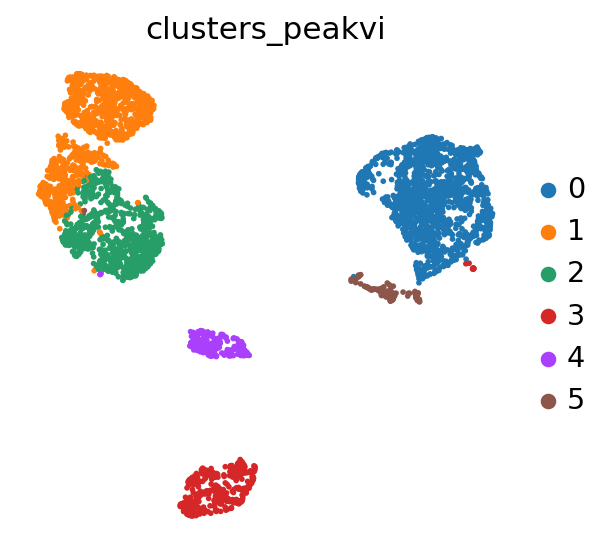

In [15]:
sc.pl.umap(adata, color=PEAKVI_CLUSTERS_KEY)

## Differential accessibility

Finally, we can use PeakVI to identify regions that are differentially accessible. There are many different ways to run this analysis, but the simplest is comparing one cluster against all others, or comparing two clusters to each other. In the first case we'll be looking for marker-regions, so we'll mostly want a one-sided test (the significant regions will only be the ones preferentially accessible in our target cluster). In the second case we'll use a two-sided test to find regions that are differentially accessible, regardless of direction.

We demonstrate both of these next, and do this in two different ways: (1) more convenient but less flexible: using an existing factor to group the cells, and then comparing groups. (2) more flexible: using cell indices directly.

```{important}
If the data includes multiple batches, we encourage setting `batch_correction=True` so the model will sample from multiple batches when computing the differential signal. We do this below despite the data only having a single batch, as a demonstration.
```

In [16]:
# (1.1) using a known factor to compare two clusters
## two-sided is True by default, but included here for emphasis
da_res11 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="3", group2="0", two_sided=True
)

# (1.2) using a known factor to compare a cluster against all other clusters
## if we only provide group1, group2 is all other cells by default
da_res12 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY, group1="3", two_sided=False
)

# (2.1) using indices to compare two clusters
## we can use boolean masks or integer indices for the `idx1` and `idx2` arguments
da_res21 = model.differential_accessibility(
    idx1=adata.obs[PEAKVI_CLUSTERS_KEY] == "3",
    idx2=adata.obs[PEAKVI_CLUSTERS_KEY] == "0",
    two_sided=True,
)
# (2.2) using indices to compare a cluster against all other clusters
## if we don't provide idx2, it uses all other cells as the contrast
da_res22 = model.differential_accessibility(
    idx1=np.where(adata.obs[PEAKVI_CLUSTERS_KEY] == "3"),
    two_sided=False,
)

da_res22.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr2:232535623-232538141,1.0,True,18.420681,-0.882698,-0.561986,0.930892,0.048194,0.590308,0.028322
chr11:60222766-60223569,1.0,True,18.420681,-0.909804,-0.516749,0.928111,0.018306,0.526432,0.009683
chr22:22776937-22777587,1.0,True,18.420681,-0.686685,-0.349928,0.722180,0.035496,0.367841,0.017913
chr3:13151900-13153013,1.0,True,18.420681,-0.859640,-0.479738,0.904662,0.045022,0.506608,0.026870
chr3:122294823-122297353,1.0,True,18.420681,-0.739251,-0.416631,0.872822,0.133571,0.491189,0.074558


Note that `da_res11` and `da_res21` are equivalent, as are `da_res12` and `da_res22`.
The return value is a pandas DataFrame with the differential results and basic properties of the comparison:

`prob_da` in our case is the probability of cells from cluster 0 being more than 0.05 (the default minimal effect) more accessible than cells from the rest of the data.

`is_da_fdr` is a conservative classification (True/False) of whether a region is differential accessible. This is one way to threshold the results.

`bayes_factor` is a statistical significance score. It doesn't have a commonly acceptable threshold (e.g 0.05 for p-values), bu we demonstrate below that it's well calibrated to the effect size.

`effect_size` is the effect size, calculated as `est_prob1 - est_prob2`.

`emp_effect` is the empirical effect size, calculated as `emp_prob1 - emp_prob2`.

`est_prob{1,2}` are the estimated probabilities of accessibility in group1 and group2.

`emp_prob{1,2}` are the empirical probabilities of detection (how many cells in group X was the region detected in).

We can make sure the probability of DA is well calibrated, and look at the regions that are identified as differentially accessible:

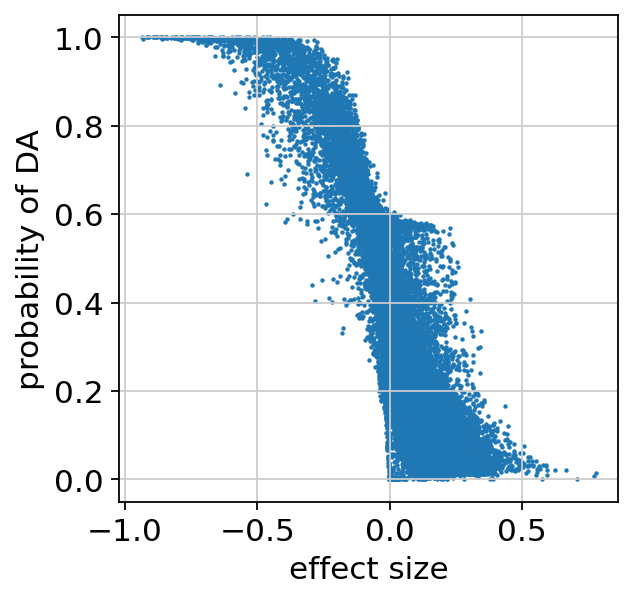

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr2:232535623-232538141,1.0,True,18.420681,-0.882698,-0.561986,0.930892,0.048194,0.590308,0.028322
chr16:67550946-67553518,1.0,True,18.420681,-0.746944,-0.377424,0.796463,0.049519,0.403084,0.025660
chr11:60222766-60223569,1.0,True,18.420681,-0.909804,-0.516749,0.928111,0.018306,0.526432,0.009683
chr5:55883388-55885472,1.0,True,18.420681,-0.755661,-0.427810,0.952137,0.196477,0.539648,0.111837
chr3:186733593-186735658,1.0,True,18.420681,-0.630135,-0.329764,0.692410,0.062275,0.361233,0.031469
chr8:28195531-28197587,1.0,True,18.420681,-0.846311,-0.540684,0.937371,0.091060,0.590308,0.049625
chr15:89199014-89200987,1.0,True,18.420681,-0.477286,-0.235269,0.534093,0.056807,0.264317,0.029049
chr4:2852856-2854873,1.0,True,18.420681,-0.532579,-0.268864,0.605137,0.072558,0.303965,0.035100
chr7:1062511-1064563,1.0,True,18.420681,-0.790935,-0.470831,0.824037,0.033101,0.488987,0.018155
chr19:17886105-17887874,1.0,True,18.420681,-0.640419,-0.321826,0.684176,0.043758,0.343612,0.021786


In [17]:
plt.scatter(da_res22.effect_size, da_res22.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res22.loc[da_res22.is_da_fdr].sort_values("prob_da", ascending=False).head(10)

We can now examine these regions to understand what is happening in the data, using various different annotation and enrichment methods. For instance, `chr11:60222766-60223569`, one of the regions preferentially accessible in cluster 0, is the promoter region of [`MS4A1`](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MS4A1), also known as `CD20`, a known B-cell surface marker, indicating that cluster 0 are probably B-cells.